# Analyse Full spectrum calibration

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : May 30th  2022
- last update : June 2nd 2022

### 
- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

from astropy import units as u

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [123]:
from scipy import interpolate

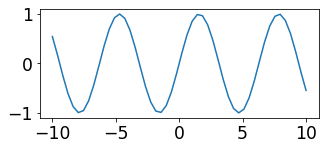

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-06-02'

In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.8.4'

In [11]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor import dispersers
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines,calibrate_spectrum
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA,HEPSILON,O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [12]:
sys.path.append('../../simulation/atmsim/libradtran')

In [13]:
import libsimulateVisible

libradtranpath= /sps/lsst/groups/auxtel/softs/utils/External/libRadtran/


In [14]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [15]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [16]:
from time import sleep

In [17]:
from astropy.time import Time
import astropy.units as u

In [18]:
DCCD   = 181.45 # mm
#DCCD   = 200.0 # mm
PIXELW = 0.01   # mm (10 microns)

## Dispersion relation
$$
x = D \frac{N_{eff} \lambda}{\sqrt{1-(N_{eff} \lambda)^2}}
$$

In [19]:
def Dispersion(wl,neff,D):
    """ 
    Dispersion(wl,a,D) : number of dx per wavelength
    input arguments:
    - wl : wavelength in mm
    - neff  : number of lines per mm
    - D  : Distance CCD-Hologram per mm
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx, x in mm and lambdas in mm
    """
    X=D*neff*wl/np.sqrt(1-(wl*neff)**2)
    return X


In [20]:
def Dispersion_Rate(wl,neff,D):
    """
    Dispersion_Rate(wl) : number of dx per wavelength
    input arguments:
    - wl : wavelength in mm
    - neff  : nb lines per mm 
    - D  : Distance CCD-Hologram in mm
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx/dlambda, x in mm and lambdas in mm
    
    """
    dxdlambda=D*neff*(np.sqrt(1-(wl*neff)**2)+ (wl*neff)**2)/(1-(wl*neff)**2)
    #dxdlambda=D*neff/(np.sqrt(1-(wl*neff)**2))**3
    return dxdlambda 

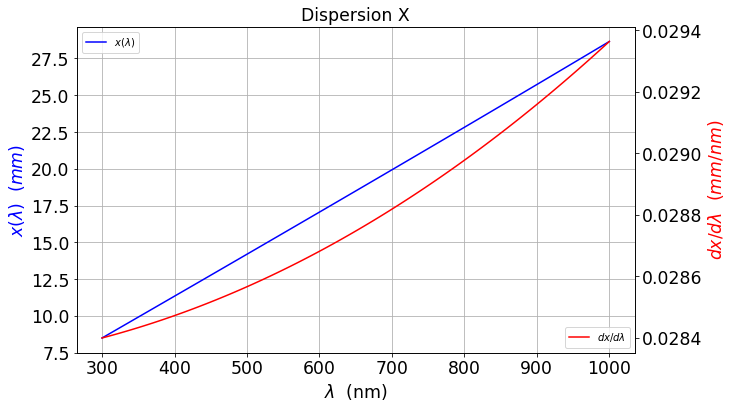

In [21]:
fig, ax1 = plt.subplots(figsize=(10,6))
WL=np.linspace(300.,1000.,100)
neff=156. # lines per mm
D=184.45 # mm

Y1=Dispersion(WL*1e-6,neff,DCCD)
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  ($mm$)",color="blue")
ax1.set_title("Dispersion X")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*1e-6,neff,DCCD)*1e-6 ## mm per nm
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($mm/ nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()


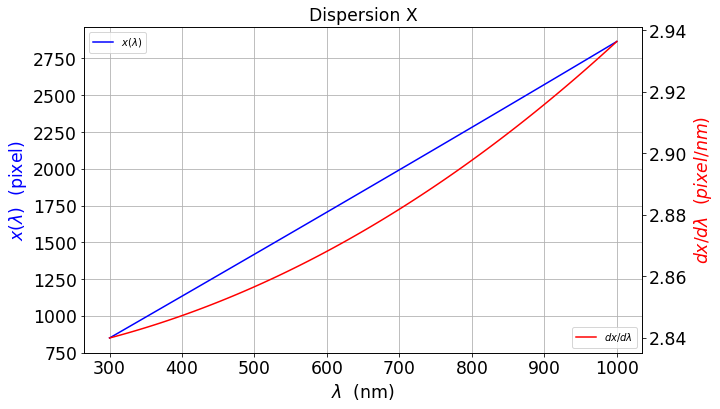

In [22]:
fig, ax1 = plt.subplots(figsize=(10,6))

Y1=Dispersion(WL*1e-6,neff,DCCD)/PIXELW   # pixel
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  (pixel)",color="blue")
ax1.set_title("Dispersion X")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*1e-6,neff,DCCD)/PIXELW*1e-6   # pixel per nm
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($pixel/nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()
fig.savefig("DispersionFormula_pixel.pdf")


# Function

In [23]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [24]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [25]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

'00330'

In [26]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

## load parameters from auxtel configuration

In [27]:
load_config("../runspectractor_standalone/2022_05/config/auxtel_config_holo_DECONVOLUTION_PSF1D.ini")

No rebinning: parameters.REBIN is forced to 1.


In [28]:
parameters.debug=True
parameters.verbose=True
parameters.display=True

In [29]:
DATE="20220316"

#/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configH/20220316/2022031600330/basespec

# Input file

/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400508/basespec

In [30]:
top_path = "/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configH"

In [31]:
exposure ="2022031600331"

In [32]:
path=os.path.join(os.path.join(top_path,DATE),exposure)

In [33]:
path_subdir=os.path.join(path,"basespec")

In [34]:
all_files = sorted(os.listdir(path_subdir))

In [35]:
all_files 

['exposure_2022031600331_postisrccd_lines.csv',
 'exposure_2022031600331_postisrccd_spectrogram.fits',
 'exposure_2022031600331_postisrccd_spectrum.fits',
 'exposure_2022031600331_postisrccd_table.csv']

## Work with spectractor table

In [36]:
table = pd.read_csv(os.path.join(path_subdir,all_files[-1]))

In [37]:
table

,lambdas,Dx,Dy,Dy_disp_axis,flux_sum,flux_integral,flux_err,fwhm,Dy_fwhm_sup,Dy_fwhm_inf,amplitude,x_c,y_c,gamma,alpha,saturation
0,303.157739,856.571125,-7.904577,2.144045,-100.130372,1.0,17.732229,12.584937,0.465527,-16.274681,1.0,0.0,187.628873,9.523524,1.913266,8500.223028
1,303.510746,857.571125,-7.884218,2.146548,-110.357930,1.0,17.717530,12.582126,0.480017,-16.248452,1.0,1.0,187.649232,9.520756,1.913389,8500.223028
2,303.863749,858.571125,-7.863870,2.149051,-98.236942,1.0,17.728431,12.577544,0.494495,-16.222235,1.0,2.0,187.669580,9.517988,1.913511,8500.223028
3,304.216750,859.571125,-7.843534,2.151554,-144.739288,1.0,17.661160,12.573517,0.508962,-16.196031,1.0,3.0,187.689916,9.515220,1.913634,8500.223028
4,304.569749,860.571125,-7.823211,2.154057,-119.694041,1.0,17.683096,12.569519,0.523416,-16.169838,1.0,4.0,187.710239,9.512453,1.913755,8500.223028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,1109.758897,3180.571125,6.937572,7.961145,2562.944737,1.0,18.215516,6.954847,14.332513,-0.457369,1.0,2324.0,202.471022,3.809696,1.144156,8500.223028
2325,1110.097388,3181.571125,6.929973,7.963648,2612.775185,1.0,18.287853,6.953675,14.326491,-0.466544,1.0,2325.0,202.463423,3.807547,1.143371,8500.223028
2326,1110.435869,3182.571125,6.922362,7.966151,2621.947998,1.0,18.309213,6.952615,14.320469,-0.475744,1.0,2326.0,202.455813,3.805399,1.142585,8500.223028
2327,1110.774341,3183.571125,6.914740,7.968654,2558.262089,1.0,18.239637,6.953620,14.315582,-0.486103,1.0,2327.0,202.448190,3.803250,1.141799,8500.223028


Text(0.5, 1.0, 'Table : wavelength calib in Spectractor')

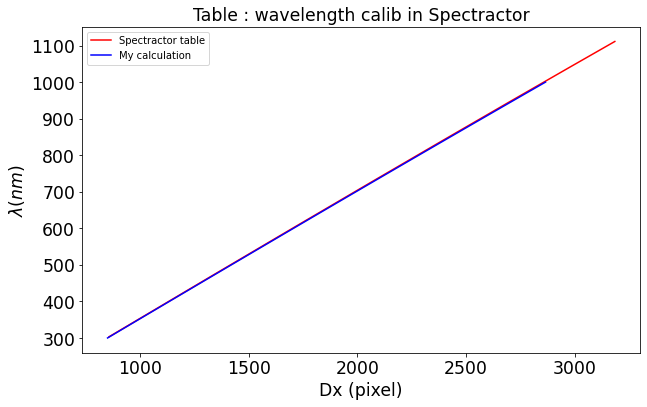

In [38]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(table.Dx,table.lambdas,"r-",label="Spectractor table")
ax.plot(Y1,WL,"b-",label="My calculation")
ax.set_xlabel("Dx (pixel)")
ax.set_ylabel("$\lambda (nm)$")
ax.legend()
ax.set_title("Table : wavelength calib in Spectractor")

Text(0.5, 1.0, 'wavelength calib in Spectractor table')

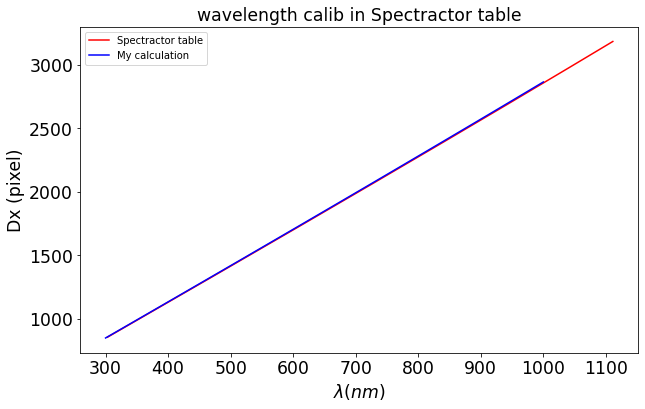

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(table.lambdas,table.Dx,"r-",label="Spectractor table")
ax.plot(WL,Y1,"b-",label="My calculation")
ax.set_ylabel("Dx (pixel)")
ax.set_xlabel("$\lambda (nm)$")
ax.legend()
ax.set_title("wavelength calib in Spectractor table")

Text(0.5, 1.0, 'wavelength calib in Spectractor table')

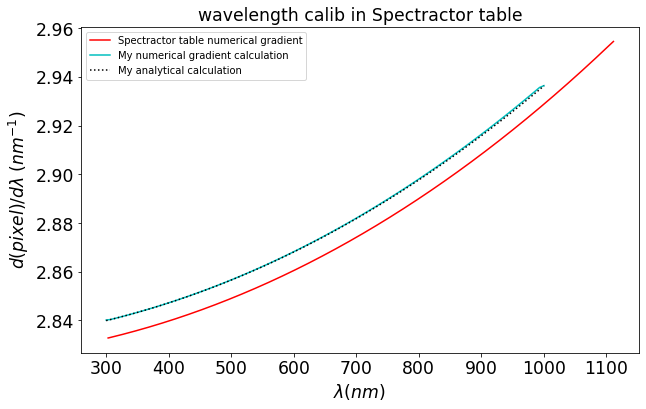

In [40]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(table.lambdas,np.gradient(table.Dx,table.lambdas),"r-",label="Spectractor table numerical gradient")
ax.plot(WL,np.gradient(Y1,WL),"c-",label="My numerical gradient calculation")
ax.plot(WL, Y2,"k:",label="My analytical calculation")
ax.set_ylabel("$d(pixel)/d\lambda \; (nm^{-1})$")
ax.set_xlabel("$\lambda (nm)$")
ax.legend()
ax.set_title("wavelength calib in Spectractor table")

Text(0, 0.5, 'ADU/pixel')

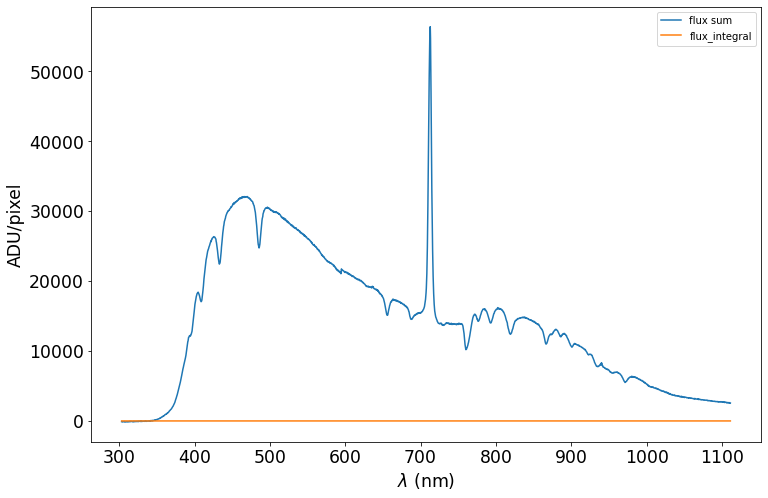

In [41]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(table.lambdas,table.flux_sum,label="flux sum")
ax.plot(table.lambdas,table.flux_integral,label="flux_integral")
ax.legend()
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("ADU/pixel")

## Spectrum

In [42]:
spectrum = Spectrum(file_name=os.path.join(path_subdir,all_files[2]))

set date_obs to 2022-03-17T01:59:56.544
set expo to 20.0
set airmass to 1.386860919079735
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.143414192888017
set dec to -66.0397222222222
set hour_angle to 42.19664412811424
set temperature to 10.6
set pressure to 743.55
set humidity to 44.0
set lambda_ref to 640.2918338104603
set parallactic_angle to 56.75888867802155


/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


target_name = etador, Selected object name for Simbad : ETA1 DOR
  MAIN_ID         RA           DEC      ...  Z_VALUE  SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                           
----------- ------------- ------------- ... --------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ... 0.0000590                1


In [43]:
spectrum.airmass

1.386860919079735

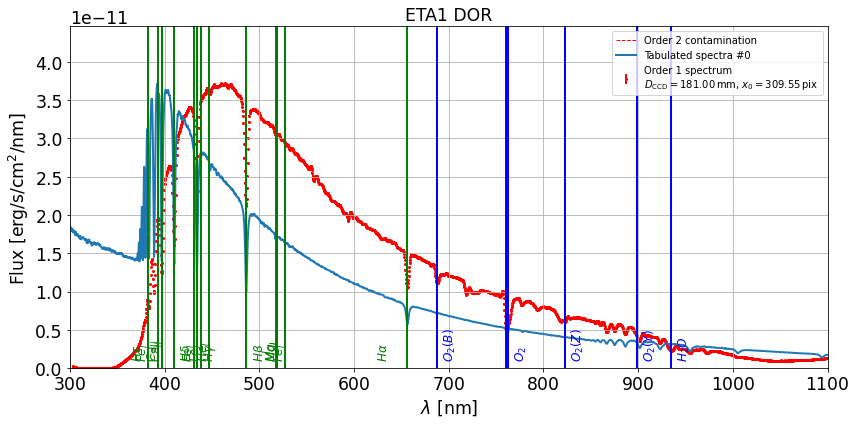

In [44]:
spectrum.plot_spectrum(xlim=[300,1100], live_fit=False, force_lines=True)

In [45]:
spectrum.target.load_spectra()

(1e-14, 1e-09)

<Figure size 720x432 with 0 Axes>

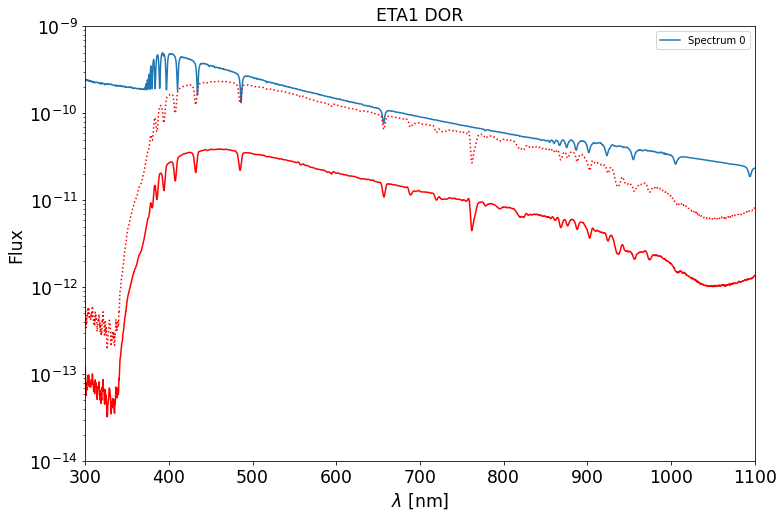

In [100]:
fig=plt.figure(figsize=(10,6))
spectrum.target.plot_spectra()
plt.plot(spectrum.lambdas,spectrum.data,'r-')
plt.plot(spectrum.lambdas,spectrum.data*6,'r:')
plt.yscale("log")
plt.ylim(1e-14,1e-9)

Text(0, 0.5, 'Fux (FLAM)')

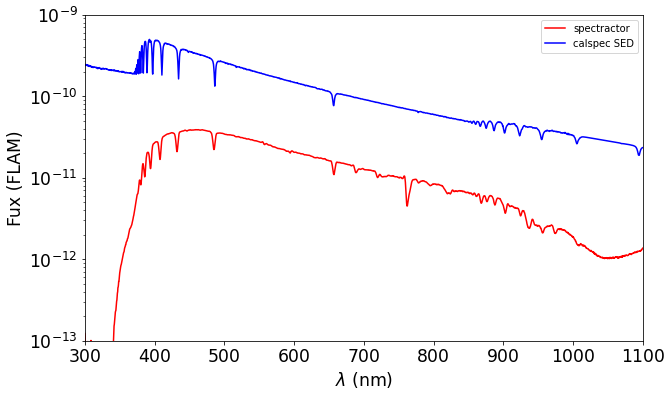

In [99]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
#spectrum.target.plot_spectra()

#ax.plot
ax.plot(spectrum.lambdas,spectrum.data,'r-',label="spectractor")
ax.plot(spectrum.target.wavelengths[0],spectrum.target.spectra[0],'b-',label="calspec SED")
ax.set_ylim(1e-13,1e-9)
ax.set_yscale("log")
ax.set_xlim(300.,1100)
ax.legend()
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("Fux (FLAM)")

In [138]:
f_sed = interpolate.interp1d(spectrum.target.wavelengths[0],spectrum.target.spectra[0],bounds_error=False,fill_value="extrapolate")
f_spec = interpolate.interp1d(spectrum.lambdas,spectrum.data,bounds_error=False,fill_value="extrapolate")

## Simulate atmosphere

In [154]:
am       = spectrum.airmass
pressure = 0. # use default value
pwv      = 4.0
aer      = 1.0
ozone    = 300.
cloudext = 0

In [155]:
path,thefile=libsimulateVisible.ProcessSimulation(am,pwv,ozone,pressure,prof_str='us',proc_str='sa',cloudext=cloudext)
data = np.loadtxt(os.path.join(path,thefile))
wl = data[:,0]
atm = data[:,1] 

Text(0.5, 1.0, 'atmospheric transmission')

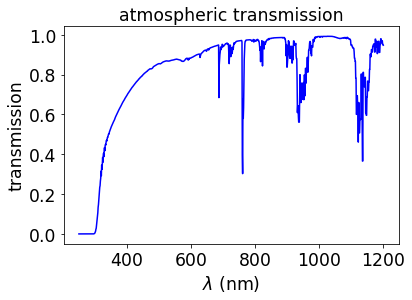

In [156]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.plot(wl,atm,"b-")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_title("atmospheric transmission")

In [157]:
f_atm = interpolate.interp1d(wl,atm,bounds_error=False,fill_value="extrapolate")

### Throughput

In [158]:
filename = "../../simulation/throughputs/AuxTel-throughput.xlsx"

In [159]:
dft = pd.read_excel(filename,header=1,index_col=0)
dft.reset_index(inplace=True)
dft['index'] = df.reset_index().index
dft.set_index('index')
dft.rename(columns={'lambda':'lambdas'},inplace = True)

In [160]:
dft

,index,lambdas,M1,M2,M3 (45°),windows per face,4 faces,total optics (except holo),holo,CCD,throughput,x10
0,0,350,0.85,0.95,0.95,0.0125,0.05,0.728769,NaN,0.645,NaN,NaN
1,1,400,0.86,0.97,0.94,0.0125,0.05,0.744941,0.120,0.750,0.067045,0.670447
2,2,450,0.87,0.96,0.97,0.0125,0.05,0.769637,0.294,0.850,0.192332,1.923322
3,3,500,0.88,0.97,0.98,0.0125,0.05,0.794702,0.312,0.870,0.215714,2.157138
4,4,550,0.88,0.98,0.98,0.0125,0.05,0.802894,0.301,0.880,0.212671,2.126707
5,5,600,0.88,0.98,0.97,0.0125,0.05,0.794702,0.272,0.900,0.194543,1.945430
6,6,650,0.88,0.98,0.97,0.0125,0.05,0.794702,0.252,0.920,0.184244,1.842436
7,7,700,0.87,0.97,0.98,0.0125,0.05,0.785671,0.226,0.950,0.168684,1.686835
8,8,750,0.86,0.97,0.98,0.0125,0.05,0.776640,0.203,0.960,0.151352,1.513516
9,9,800,0.86,0.97,0.98,0.0125,0.05,0.776640,0.184,0.960,0.137186,1.371857


Text(0.5, 1.0, 'auxtel throughput')

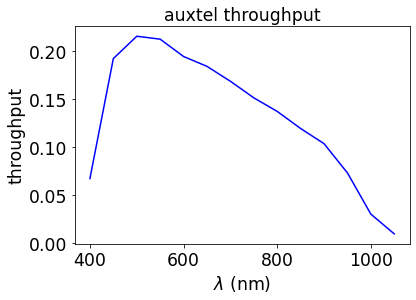

In [161]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.plot(dft.lambdas,dft.throughput,"b-")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("throughput")
ax.set_title("auxtel throughput")

In [162]:
f_thr = interpolate.interp1d(dft.lambdas,dft.throughput,bounds_error=False,fill_value="extrapolate")

# SED x Throughput x Atmosphere

In [163]:
WL = np.arange(400.,1050.)

flux_predicted = f_sed(WL) * f_thr(WL) * f_atm(WL) 
flux_measured  = f_spec(WL)

Text(0, 0.5, ' Flux (FLAM)')

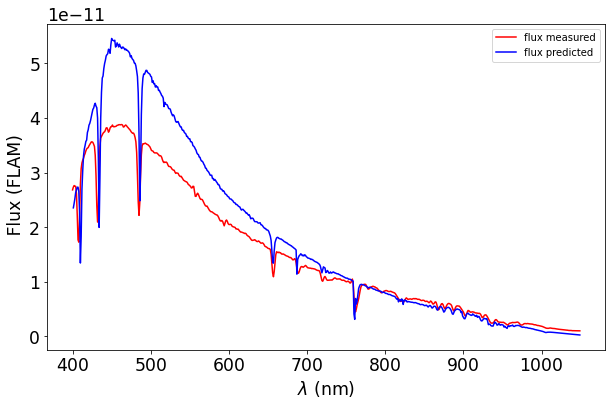

In [164]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)

ax.plot(WL,flux_measured,'r-',label= "flux measured")
ax.plot(WL,flux_predicted,'b-',label= "flux predicted")
ax.legend()
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel(" Flux (FLAM)")

# Pixel Wavelength calibration

In [50]:
spectrum.x0

[309.5503503431062, 1738.402360690092]

In [51]:
spectrum.order

1

In [52]:
spectrum.disperser.full_name

'Phase hologram #4-003'

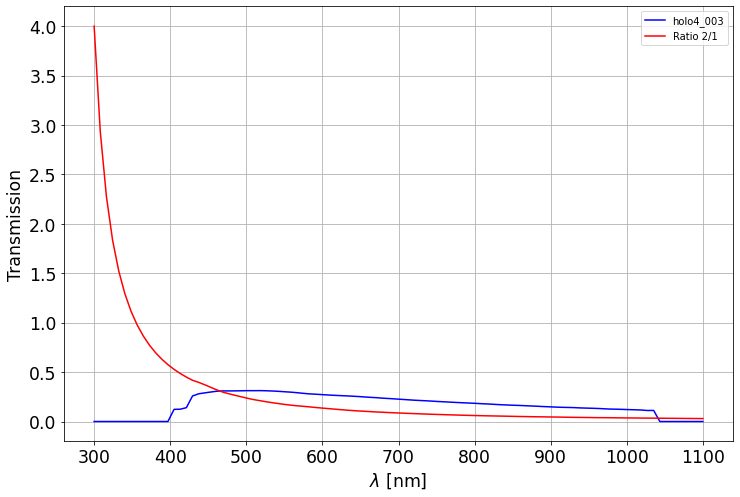

In [53]:
spectrum.disperser.plot_transmission()

## Ask spectrum for the dispersion relation

In [54]:
spectrum.disperser.N([2000.,300.])

156

In [55]:
spectrum.disperser.load_specs()

## Fix the pixel grid and pixel range 

In [56]:
pix_distance=np.arange(1,3000)

In [57]:
spectrum_lambdas = spectrum.disperser.grating_pixel_to_lambda(pix_distance, spectrum.x0, order=spectrum.order)

In [58]:
# spectrum.lambdas_binwidths = np.gradient(spectrum.lambdas)   # probably dlambda/dNpix (pix)
# assume spectrum.lambdas be regular in pixel, this may not be the case

In [59]:
spectrum_lambdas_binwidth = spectrum.lambdas_binwidths
1/spectrum_lambdas_binwidth

array([2.83280955, 2.83282047, 2.83284233, ..., 2.95441511, 2.9544983 ,
       2.95453991])

In [60]:
dispersers.get_theta0(spectrum.x0)

-0.0008023686137182023

In [61]:
dispersers.get_theta0([1000.,8])

-0.00048369667038825965

Text(0.5, 1.0, 'Spectrum : Pixel vs wavelength calibration')

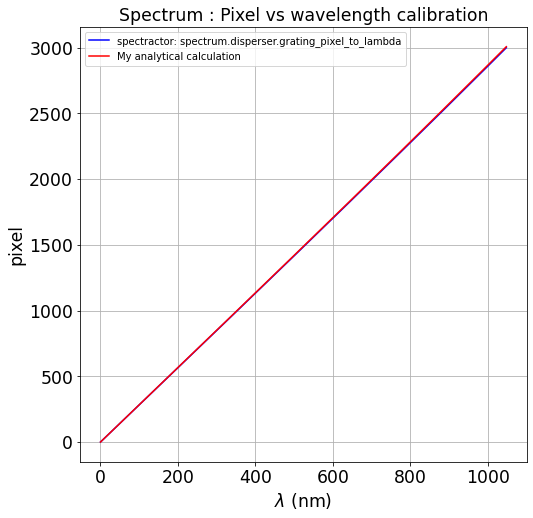

In [62]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(spectrum_lambdas,pix_distance,'b-',label="spectractor: spectrum.disperser.grating_pixel_to_lambda")
my_x_pix = Dispersion(spectrum_lambdas*1e-6,neff,DCCD)/PIXELW   # pixel per nm
ax.plot(spectrum_lambdas,my_x_pix,'r-',label="My analytical calculation")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("pixel")
ax.grid()
ax.legend()
ax.set_title("Spectrum : Pixel vs wavelength calibration")

Text(0.5, 1.0, 'Spectrum : Pixel gradient vs wavelength calibration')

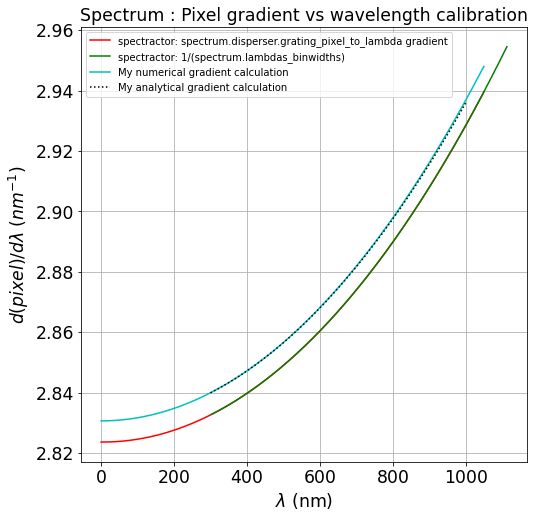

In [63]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(spectrum_lambdas,np.gradient(pix_distance,spectrum_lambdas),'r-',label="spectractor: spectrum.disperser.grating_pixel_to_lambda gradient")
ax.plot(spectrum.lambdas,1/spectrum.lambdas_binwidths,"g",label="spectractor: 1/(spectrum.lambdas_binwidths)")
ax.plot(spectrum_lambdas,np.gradient(my_x_pix,spectrum_lambdas),'c-',label="My numerical gradient calculation")
ax.plot(WL, Y2,"k:",label="My analytical gradient calculation")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("$d(pixel)/d\lambda \; (nm^{-1})$")
ax.legend()
ax.grid()
ax.set_title("Spectrum : Pixel gradient vs wavelength calibration")

In [64]:
spectrum.lambdas_binwidths

array([0.35300643, 0.35300507, 0.35300235, ..., 0.33847647, 0.33846694,
       0.33846217])

In [65]:
1/spectrum.lambdas_binwidths

array([2.83280955, 2.83282047, 2.83284233, ..., 2.95441511, 2.9544983 ,
       2.95453991])

In [66]:
spectrum.lambdas

array([ 303.15773911,  303.51074555,  303.86374926, ..., 1110.43586897,
       1110.77434068, 1111.11280285])

# Try to recalibrate in wavelegth

In [67]:
wavelength_array = calibrate_spectrum(spectrum, with_adr=True)

2022-06-02 18:19:14  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.


In [68]:
wavelength_array 

array([ 295.81834486,  296.1973301 ,  296.57620701, ..., 1112.329291  ,
       1112.66810999, 1113.00691904])

In [69]:
pixel_grid = spectrum.disperser.grating_lambda_to_pixel(wavelength_array , x0=[0,0], order=1)

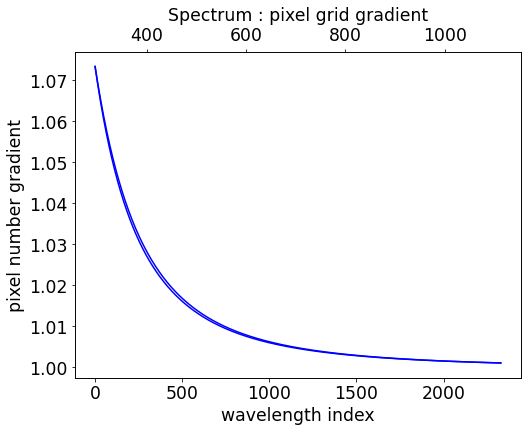

In [70]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.plot(np.gradient(pixel_grid),"b-")
ax.set_xlabel("wavelength index")
ax.set_ylabel("pixel number gradient")
ax.set_title("Spectrum : pixel grid gradient")
ax2 = ax.twiny()
ax2.plot(wavelength_array,np.gradient(pixel_grid),"b-")

In [71]:
my_lambdas = spectrum.disperser.grating_pixel_to_lambda(pix_distance, spectrum.x0, order=spectrum.order)

Text(0.5, 1.0, 'Spectrum : Pixel vs wavelength calibration')

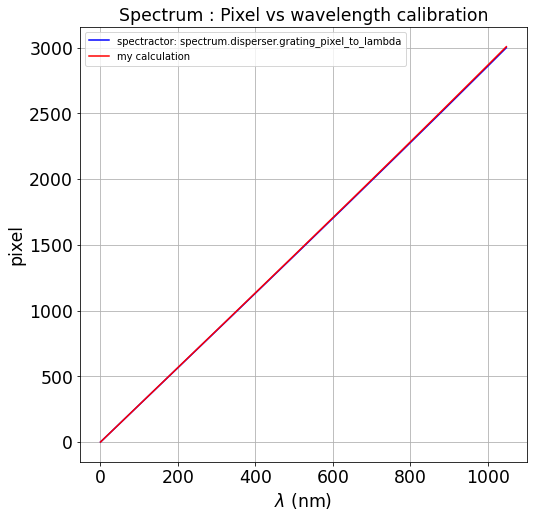

In [72]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(my_lambdas,pix_distance,'b-',label="spectractor: spectrum.disperser.grating_pixel_to_lambda")
x_pix = Dispersion(my_lambdas*1e-6,neff,DCCD)/PIXELW   # pixel per nm
ax.plot(my_lambdas,x_pix,'r-',label="my calculation")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("pixel")
ax.grid()
ax.legend()
ax.set_title("Spectrum : Pixel vs wavelength calibration")

# My spectrum calculation from Table

- $S_\lambda(\lambda)$ : SED in erg/cm2/s/nm
- FLAM to ADU
$$
\frac{dN_{ADU}(\lambda)}{dN_{pix}} = \left( \frac{S \Delta T \epsilon_{eq}(\lambda)}{G_{el}} \right) \frac{1}{hc} \lambda \frac{d\lambda}{dN_{pix}} \cdot S_\lambda(\lambda)
$$

- ADU to FLAM

$$
S_\lambda(\lambda) = \frac{dn_\gamma(\lambda)}{d\lambda} = \frac{G_{el}}{S\Delta T \epsilon_{QE}(\lambda)} (hc) \frac{1}{\lambda} \left( \frac{dN_{pix}}{d\lambda}\right) \left(\frac{dN_{ADU}}{dN_{pix}} \right)
$$


- FLAM to ADU constant:
$$
FLAM\_TO\_ADURATE = \left( \frac{S}{G_{el}} \right) \frac{1}{hc} \times \left[ TIME \right ]_{unit}  \times \left[ \lambda d\lambda \right]_{unit}
\times \left[ SED \right ]_{unit} 
$$

In [73]:
import astropy.units as units
from astropy import constants as const

In [74]:
# spectrum.lambdas_binwidths = np.gradient(spectrum.lambdas)   # probably dlambda/dNpix (pix)
# ldl = parameters.FLAM_TO_ADURATE * self.lambdas * np.abs(self.lambdas_binwidths)
# self.data /= ldl

In [75]:
parameters.FLAM_TO_ADURATE

5175865186660.421

In [76]:
parameters.OBS_DIAMETER  # OK

<Quantity 1.2 m>

In [77]:
(parameters.OBS_DIAMETER)**2/4*np.pi

<Quantity 1.13097336 m2>

In [78]:
parameters.OBS_SURFACE # OK

<Quantity 1.13097336 m2>

In [79]:
parameters.CCD_GAIN # OK

1.1

In [80]:
parameters.hc  # OK

<Quantity 1.98644586e-25 J m>

In [81]:
# Conversion factor
# Units of SEDs in flam (erg/s/cm2/nm) :
SED_UNIT = 1 * units.erg / units.s / units.cm ** 2 / units.nanometer
TIME_UNIT = 1 * units.s  # flux for 1 second
hc = const.h * const.c  # h.c product of fontamental constants c and h
wl_dwl_unit = units.nanometer ** 2  # lambda.dlambda  in wavelength in nm
FLAM_TO_ADURATE = ((parameters.OBS_SURFACE * SED_UNIT * TIME_UNIT * wl_dwl_unit / hc / parameters.CCD_GAIN).decompose()).value

In [82]:
FLAM_TO_ADURATE

5175865186660.421

In [83]:
# my calculation of the spectrum
my_spectrum = table.flux_sum / parameters.FLAM_TO_ADURATE/table.lambdas * np.gradient(table.Dx,table.lambdas)

Text(0.5, 1.0, 'Comparison Spectra : Spectrum calculation and my calculation')

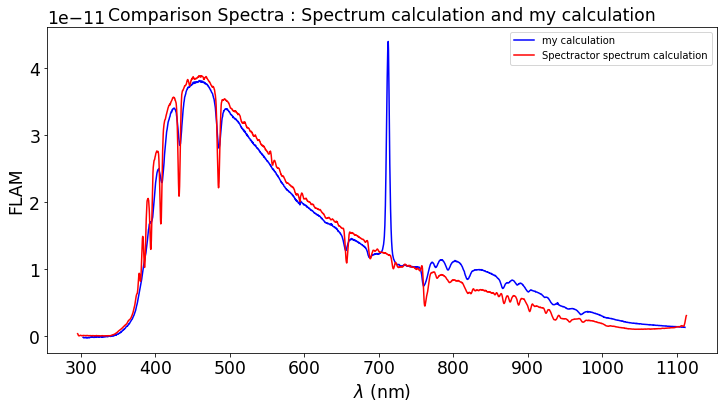

In [84]:
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)
ax.plot(table.lambdas,my_spectrum,color="b",label="my calculation")
ax.plot(spectrum.lambdas,spectrum.data,color="r",label="Spectractor spectrum calculation")
ax.legend()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("FLAM")
ax.set_title("Comparison Spectra : Spectrum calculation and my calculation")